## import

In [1]:
!pip3 install tensorflow_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import tensorflow_hub as tfhub 

## Data

248185/248185 [==============================] - 1s 4us/step


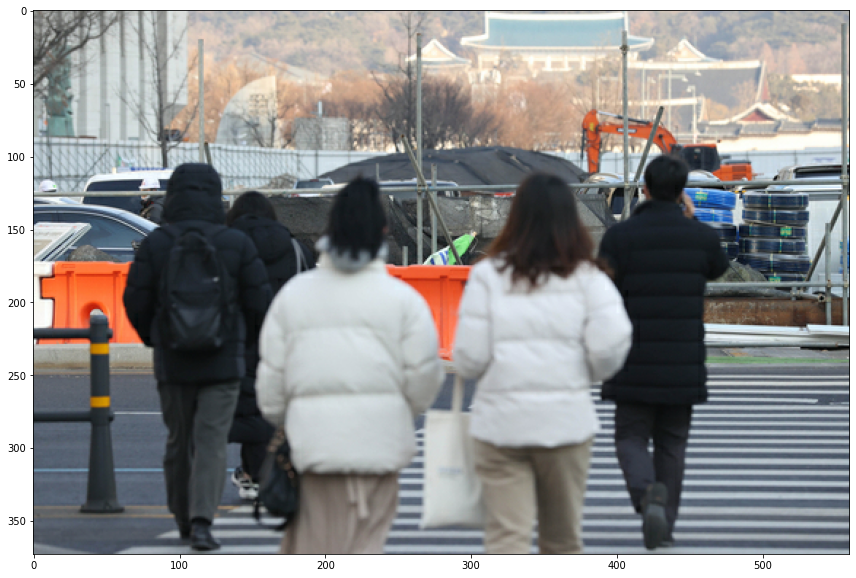

In [3]:
img_path = "https://imgnews.pstatic.net/image/009/2023/02/01/0005081888_001_20230201065801006.jpg"
img = tf.keras.utils.get_file(origin=img_path)
img = tf.io.read_file(img) 
img = tf.image.decode_jpeg(img, channels=3)
img = tf.image.convert_image_dtype(img, tf.float32) 

import matplotlib.pylab as plt
plt.figure(figsize=(15, 10))
plt.imshow(img)

In [4]:
img_input = tf.expand_dims(img, 0)  # 맨 앞 차원에 batch_size 추가
img_input.shape

TensorShape([1, 373, 560, 3])

## Model

In [5]:
# tensorhub에서 모델 다운로드
model = tfhub.load("https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1")

In [7]:
# 객체인식 탐지 모델  확인
model.signatures.keys()

KeysView(_SignatureMap({'default': <ConcreteFunction pruned(images) at 0x7F54B03C0610>}))

In [8]:
# signature 지정
obj_detector = model.signatures['default']
obj_detector

<ConcreteFunction pruned(images) at 0x7F54B03C0610>

In [9]:
result = obj_detector(img_input)
result.keys()

dict_keys(['detection_class_labels', 'detection_scores', 'detection_boxes', 'detection_class_entities', 'detection_class_names'])

In [10]:
len(result["detection_scores"])

100

In [15]:
import numpy as np
np.sum(result["detection_scores"]>0.5)

4

## 시각화

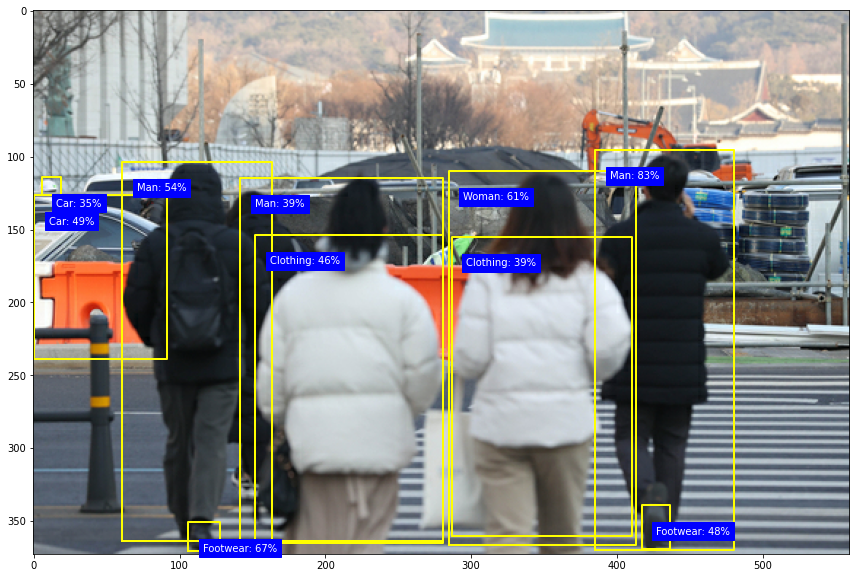

In [17]:
boxes = result["detection_boxes"] # BB 의 좌표 예측
labels = result["detection_class_entities"] # class
scores = result["detection_scores"] # confidence

# 이미지의 가로 세로 크기
img_height, img_width = img.shape[0], img.shape[1]

# 탐지할 객체의 수
obj_to_detect = 10
 
plt.figure(figsize=(15, 10))
for i in range(min(obj_to_detect, boxes.shape[0])):    
    if scores[i] >= 0.3:
        (ymax, xmin, ymin, xmax) = (boxes[i][0]*img_height, boxes[i][1]*img_width,
                                    boxes[i][2]*img_height, boxes[i][3]*img_width)
                                    
        plt.imshow(img)
        plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin],
                 color='yellow', linewidth=2)
        
        class_name = labels[i].numpy().decode('utf-8')
        infer_score = int(scores[i].numpy()*100)
        annotation = f"{class_name}: {infer_score}%"
        plt.text(xmin+10, ymax+20, annotation,
                 color='white', backgroundcolor='blue', fontsize=10)